## TODO
Mulig å begrense til max/min posisjonene i x/y til de genererte trajektorene fra datasettet?


In [20]:
import os
import glob
import torch
import minari

import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
import seaborn as sns

import torch.nn.functional as F
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm
from natsort import natsorted

In [21]:
print(f"Torch version: {torch.__version__}")
print(f"Torch cuda version: {torch.version.cuda}")

Torch version: 2.6.0
Torch cuda version: 12.6


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [23]:
def collate_fn(batch):
    observations = [torch.as_tensor(x.observations['observation']) for x in batch]
    lengths = torch.tensor([obs.shape[0] for obs in observations])  # Tensor of original lengths

    # Pad with zeros first
    padded_obs = torch.nn.utils.rnn.pad_sequence(observations, batch_first=True)

    # Use advanced indexing to replace padding with the last valid value
    mask = torch.arange(padded_obs.shape[1]).expand(len(batch), -1) >= lengths.unsqueeze(1)
    padded_obs[mask] = padded_obs[torch.arange(len(batch)), lengths - 1].unsqueeze(1).expand_as(padded_obs)[mask]

    return {
        "observations": padded_obs
    }

In [24]:
dataset = minari.load_dataset('D4RL/pointmaze/umaze-v2')
print(f"Total amount of episodes: {dataset.total_episodes}")  # 13210 episodes
batch_size = 64

dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
for batch in dataLoader:
    test_batch = batch['observations']
    print(f"test_batch.shape: {test_batch.shape}")
    break

Total amount of episodes: 13210
test_batch.shape: torch.Size([64, 171, 4])


## Dataset trajectory example
* One episode
* Based on the 'Observation' parameter of Observations.

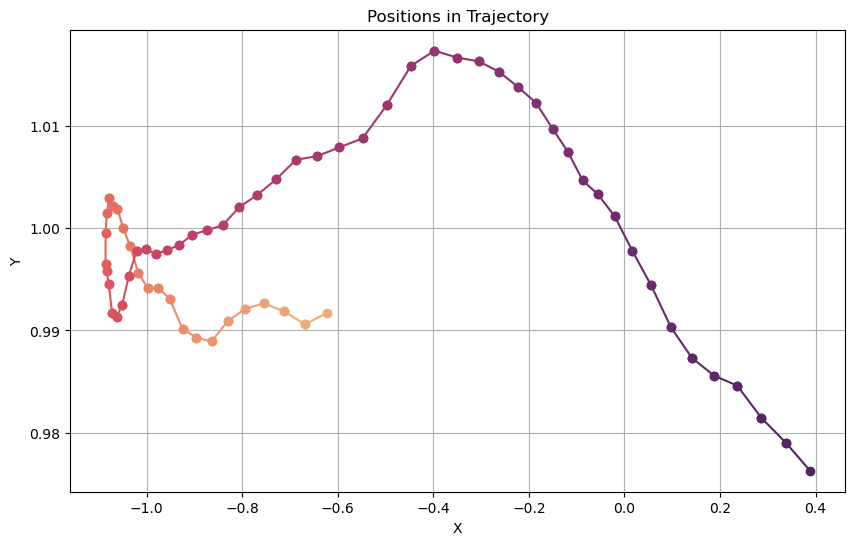

In [25]:
colors = sns.color_palette("flare", len(test_batch))

plt.figure(figsize=(10, 6))
for i in range(len(test_batch) - 1): # Traj plot
    plt.plot(test_batch[0, i:i+2, 0].cpu().numpy(), test_batch[0, i:i+2, 1].cpu().numpy(), color=colors[i], marker='o')
plt.title('Positions in Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()

plt.show()

## FLOW MATCHING

* TODO: Se på x_t uttrykket, og hva funksjonen tar inn
* Sjekk sampling output (shape)
* Sjekk at loss går nedover med trening
* Skriv i overleaf hva treningsfunksjon skal være, og sampling prosedyre
* Så implementer loss beregning og sampling.

In [26]:
class TrajectoryFlowModel(nn.Module):
    def __init__(self, obs_dim, hidden_dim=128, num_layers=5):
        """
        A neural network that estimates the velocity field for flow matching.
        
        Args:
            obs_dim (int): Dimensionality of observations (D_obs)
            hidden_dim (int): Number of hidden units in the MLP
            num_layers (int): Number of layers in the MLP
        """
        super().__init__()
        
        layers = []
        input_dim = obs_dim + 1  # We include time `t` as an input
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim  # Keep hidden layer size consistent
        
        layers.append(nn.Linear(hidden_dim, obs_dim))  # Output has the same shape as observations
        self.network = nn.Sequential(*layers)

    def forward(self, x, t):
        """
        Forward pass for the trajectory flow model.
        """
        # print(f"t.shape in model code: {t.shape}")
        sec_dim = x.shape[1]
        t_expanded = t[:, None, None].expand(-1, sec_dim, -1)
        xt = torch.cat([x, t_expanded], dim=-1).to(device, dtype=torch.float32)
        velocity = self.network(xt)  # Predict flow field

        return velocity  # Shape: (N, T, D_obs)

In [27]:
model_path = "fm_model.pt"
epochs = 10
lr = 3e-3 # Learning rate

traj_dim = 4 # [xpos, ypos, xvel, yvel]
flow_model = TrajectoryFlowModel(traj_dim).to(device)
optimizer = torch.optim.AdamW(flow_model.parameters(), lr=lr)

xt_prog = []
losses = []

for epoch in tqdm(range(epochs), desc="Training Progress"): # Se https://jmtomczak.github.io/blog/18/18_fm.html for kobling til teorien
    for batch in dataLoader:
        observations = batch['observations']
        x1 = observations[torch.randint(observations.size(0), (batch_size, ))].to(device)
        x0 = torch.rand_like(x1).to(device)
        vel_target = x1 - x0 # dxt
        t = torch.rand((x1.size(0),), device=device)
        xt = t[:, None, None] * x1 + (1 - t[:, None, None]) * x0 # See eq. (2.3) i guide and code s.5
        xt_prog.append(xt)
        prediction = flow_model(xt, t)
        loss = ((vel_target - prediction)**2).mean()
        loss = loss.to(device, dtype=torch.float32)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

torch.save(flow_model.state_dict(), model_path)

Training Progress: 100%|██████████| 10/10 [23:37<00:00, 141.72s/it]


# Load model

In [28]:
# flow_model = TrajectoryFlowModel(obs_dim=4)
flow_model.load_state_dict(torch.load(model_path, weights_only = True))
flow_model.eval()

TrajectoryFlowModel(
  (network): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=4, bias=True)
  )
)

# XT progression

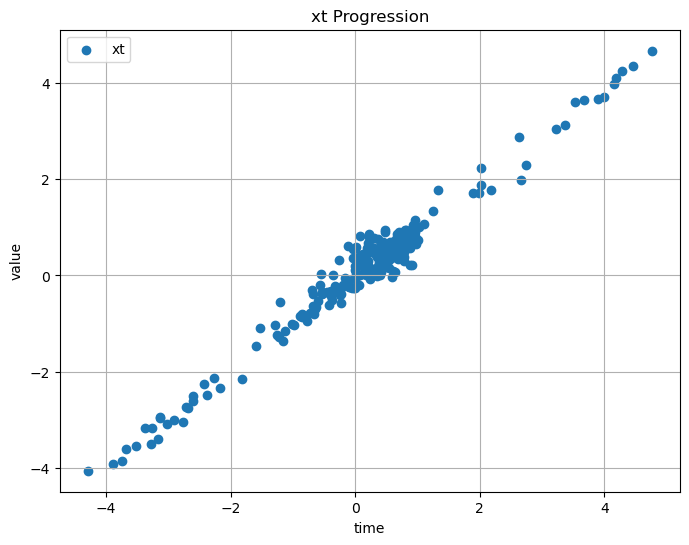

In [29]:
xt_lst = []
for ver in xt_prog:
    ver = ver.cpu().numpy()
    xt_lst.append(ver)
plt.figure(figsize=(8, 6))
plt.scatter(xt_lst[0][:, 0], xt_lst[0][:, 1], label='xt', marker='o')
plt.title('xt Progression')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
def display_images_in_pairs(save_dir):
    """
    Display images with filenames matching 'sampling_step_*.png' in natural order, two at a time.

    Args:
        save_dir (str): Directory containing the images.
    """
    image_files = natsorted(glob.glob(os.path.join(save_dir, "sampling_step_*.png")))

    for i in range(0, len(image_files), 2):
        plt.figure(figsize=(12, 6))

        for j in range(2):
            if i + j < len(image_files):
                img = plt.imread(image_files[i + j])

                plt.subplot(1, 2, j + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Step {image_files[i + j].split('_')[-1].split('.')[0]}")

        plt.show()

## ODE Solver

In [31]:
# ODE Solver w/ Midpoint method
from torchdiffeq import odeint

class FlowMatchingODEFunc(torch.nn.Module):
    def __init__(self, flow_model):
        super().__init__()
        self.flow_model = flow_model

    def forward(self, t, x_t):
        """
        Compute the velocity field at time t for input x_t.
        t: Scalar tensor (shape: []) representing time.
        x_t: Tensor of shape (batch_size, sequence_length, dim) representing the state.
        Returns: Velocity field of shape (batch_size, sequence_length, dim)
        """
        batch_size, seq_len, dim = x_t.shape
        t_expanded = t.expand(batch_size)  # Expand t to match batch size
        velocity_pred = self.flow_model(x_t, t_expanded)  # Predict velocity at (x_t, t)
        return velocity_pred  # dx/dt = velocity field


In [32]:
def sample_trajectories(flow_model, xt_ode, ode_method, sampling_steps_ode, save_dir_ode, plot_every_ode):
    """
    Uses an ODE solver to sample trajectories from the learned flow model.
    
    Parameters:
    - flow_model: The trained flow matching model.
    - xt_ode: Initial noise tensor (batch_size, seq_len, dim).
    - sampling_steps_ode: Number of integration steps.
    - save_dir_ode: Directory to save visualization images.
    - plot_every_ode: Interval for plotting intermediate steps.
    
    Returns:
    - sample_trajs: The final sampled trajectories.
    """
    device = xt_ode.device
    flow_model.eval().requires_grad_(False)

    # Define the ODE function
    ode_func = FlowMatchingODEFunc(flow_model).to(device)

    # Time grid from 0 to 1, because it integrates over time when solving ODE.
    t_eval = torch.linspace(0, 1, sampling_steps_ode, device=device)

    # Solve ODE using `odeint`
    sample_trajs = odeint(ode_func, xt_ode, t_eval, method=ode_method)  # Shape: (sampling_steps_ode, batch_size, seq_len, dim)

    # Extract final sampled trajectories
    final_samples = sample_trajs[-1] 

    # Plot intermediate snapshots
    snapshots_samples = []
    for i in range(0, sampling_steps_ode, plot_every_ode):
        snapshots_samples.append(sample_trajs[i].clone())  # Store for visualization
        
        plt.figure(figsize=(8, 6))
        for observations in observation_lst:
            plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g', alpha=0.5)

        plt.scatter(sample_trajs[i, 0, :, 0].cpu().numpy(), sample_trajs[i, 0, :, 1].cpu().numpy(), color='r', label=f"Step {i}")
        
        plt.title(f'Sampling Progression ODE (Step {i})')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.legend()

        save_path = os.path.join(save_dir_ode, f"sampling_step_ode_{i}.png")
        plt.savefig(save_path)
        plt.close()

    flow_model.train().requires_grad_(True)
    print(f"Finished sampling with: {ode_method}")
    
    return final_samples

Finished sampling with: dopri5


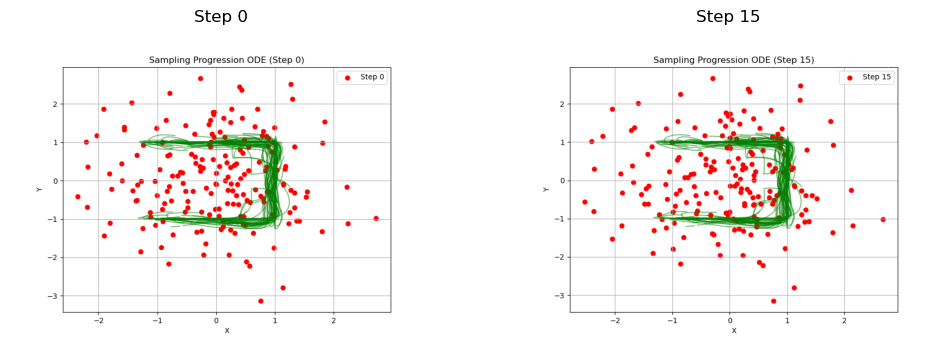

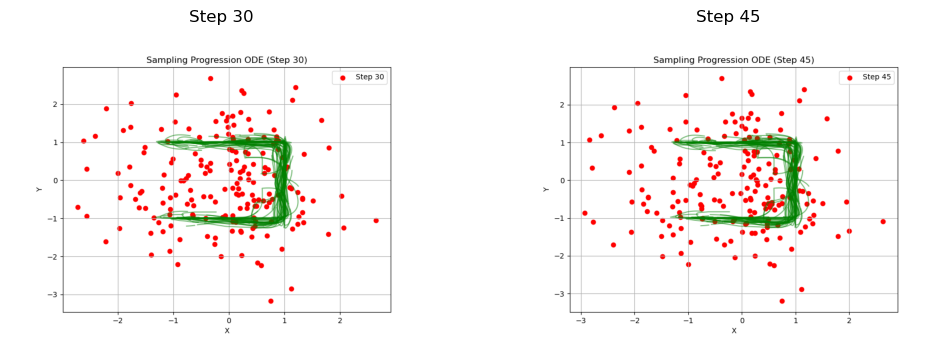

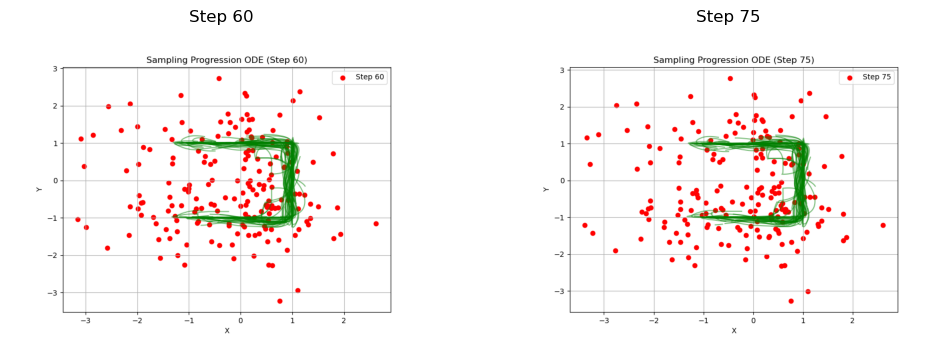

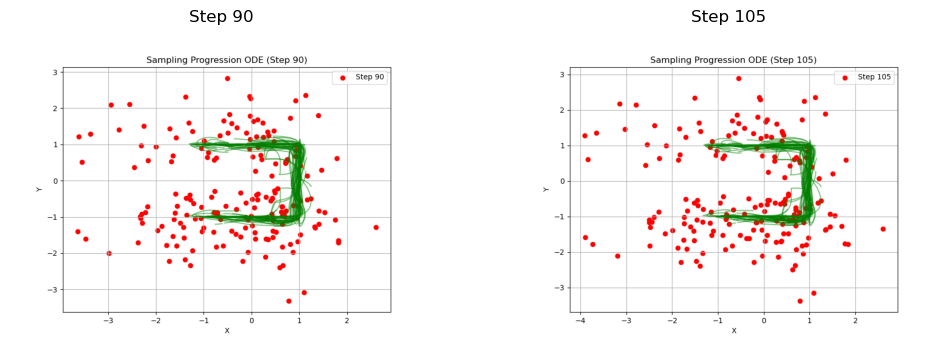

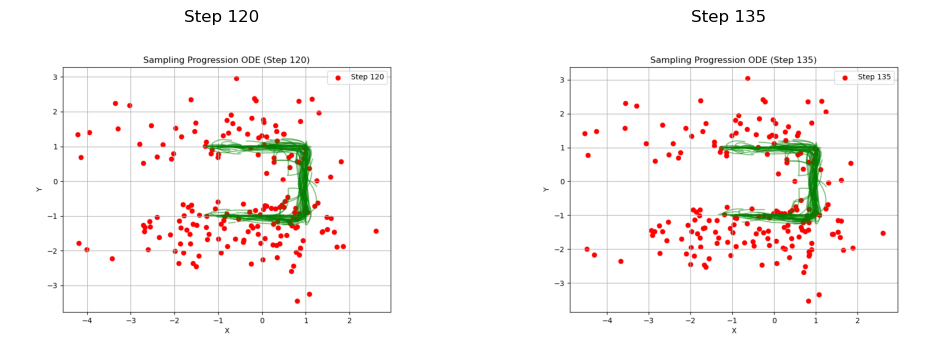

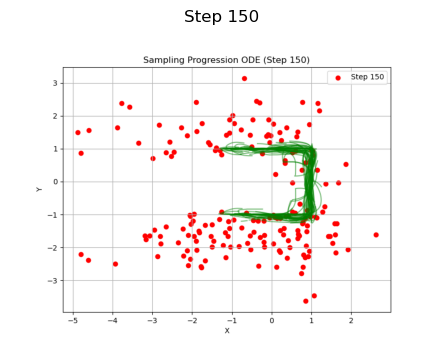

In [33]:
sampling_steps_ode = 151
save_dir_ode = "Sampling_Plots_ODE"
os.makedirs(save_dir_ode, exist_ok=True)
plot_every_ode = 15
# Available methods: ["dopri8", "dopri5", "bosh3", "fehlberg2", "adaptive_heun", "euler", "midpoint", "rk4", "explicit_adams", "implicit_adams", "fixed_adams", "scipy_solver"]
ode_method = 'dopri5'

observation_lst = []
max_batches = 100
for count, batch in enumerate(dataLoader):
    if count == max_batches:
        break
    obs = batch['observations']
    observation_lst.append(obs)

xt_ode = torch.randn_like(xt)
final_trajs_ode = sample_trajectories(flow_model, xt_ode, ode_method, sampling_steps_ode, save_dir_ode, plot_every_ode)
display_images_in_pairs(save_dir_ode)

## Euler

Finished sampling


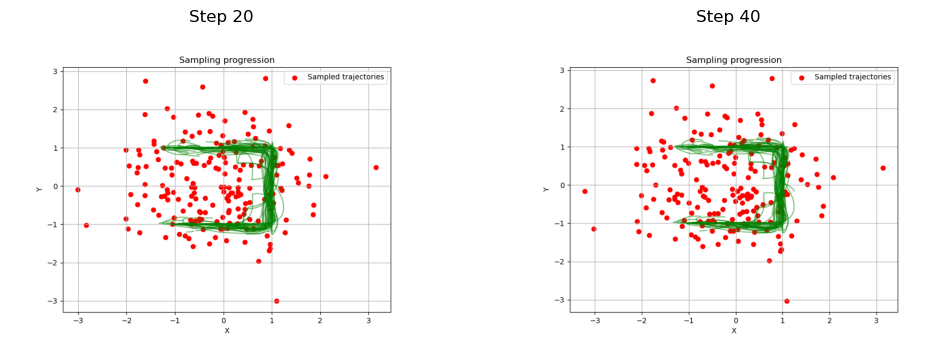

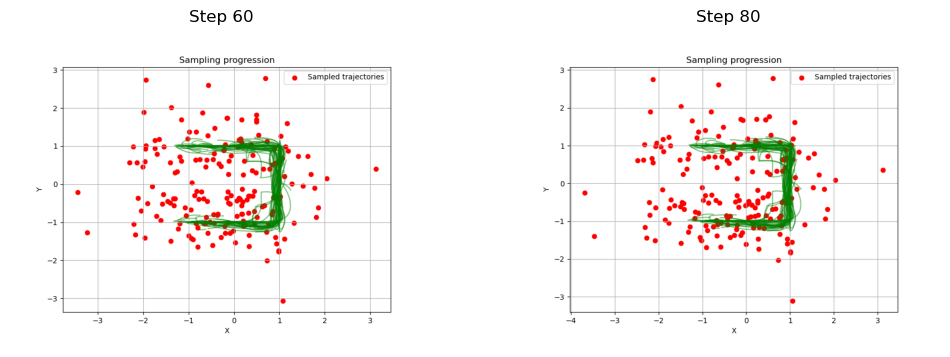

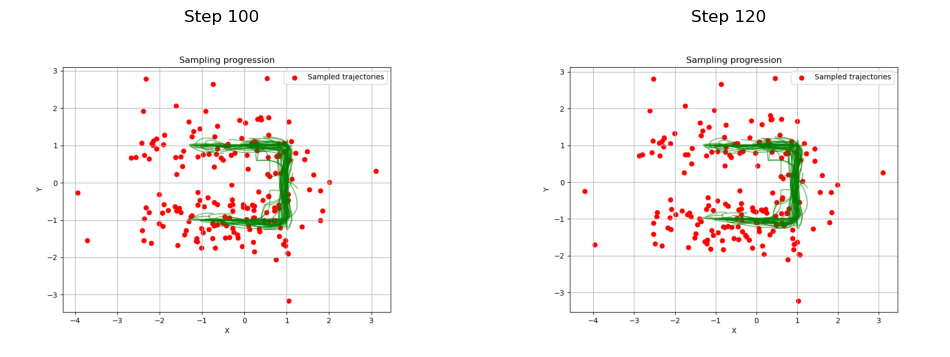

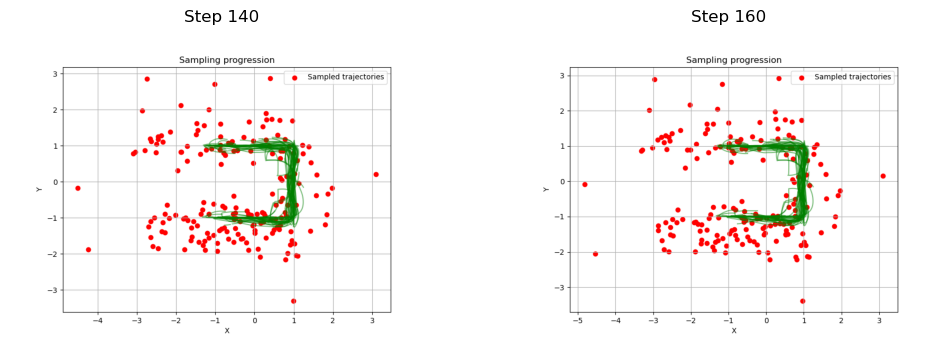

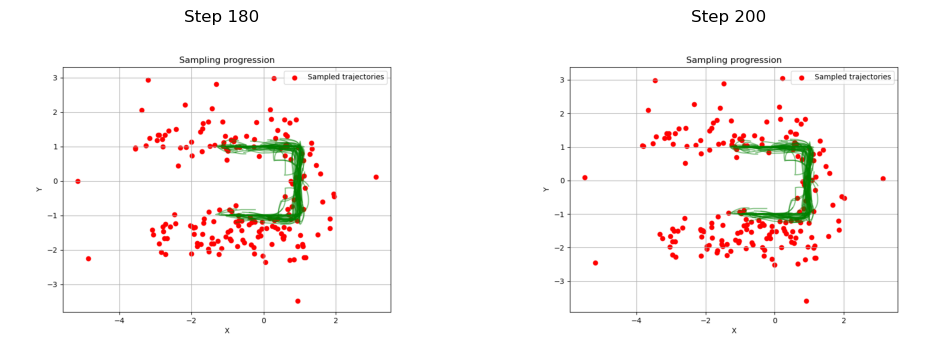

In [34]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()
save_dir = "Sampling_Plots"
os.makedirs(save_dir, exist_ok=True)

sampling_steps = 200 # Seems to not matter how many steps I take past this point.
plot_every = 20

snapshots_samples = []

sample_trajs = torch.randn_like(xt) # 64 long
flow_model.eval().requires_grad_(False)

for i, t in enumerate(torch.linspace(0, 1, sampling_steps, device=device), start = 1):
    pred = flow_model(sample_trajs, t.expand(xt.size(0)))
    sample_trajs = sample_trajs + (1 / sampling_steps) * pred
    
    if i % plot_every == 0:
        snapshots_samples.append(sample_trajs.clone())
        plt.figure(figsize=(8, 6))

        for observations in observation_lst:
            plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g', alpha=0.5)

        plt.scatter(sample_trajs[0, :, 0].cpu().numpy(), sample_trajs[0, :, 1].cpu().numpy(), color='r', label="Sampled trajectories")
        plt.title('Sampling progression')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.legend()

        save_path = os.path.join(save_dir, f"sampling_step_{i}.png")
        plt.savefig(save_path)
        
        plt.close()

flow_model.train().requires_grad_(True)
print("Finished sampling")
# print(sample_trajs)
display_images_in_pairs(save_dir)

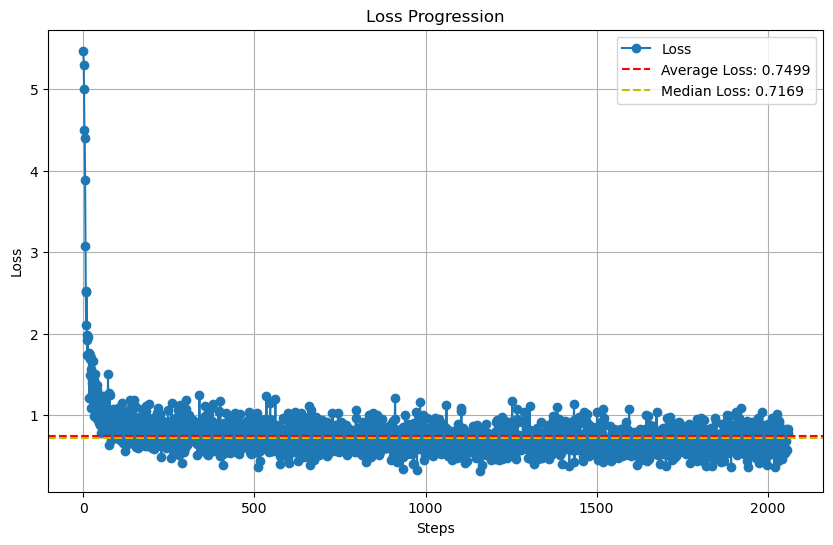

In [35]:
avg_loss = sum(losses)/len(losses)
med_loss = stat.median(losses)

save_dir = 'Plotted loss'
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, 'loss_plot.png')

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss', marker='o')
plt.axhline(y=avg_loss, color='r', linestyle='--', label=f'Average Loss: {avg_loss:.4f}')
plt.axhline(y=med_loss, color='y', linestyle='--', label=f'Median Loss: {med_loss:.4f}')
plt.title('Loss Progression')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()